In [22]:
%matplotlib inline

## Imports

In [23]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
import matplotlib.pyplot as plt
import random

## Idea:

### Create an equal superposition state by applying Hadamard gates to each qubit in the string

In [24]:
def generate_rng_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    qc.barrier()
    qc.measure(range(num_qubits), range(num_qubits))
    return qc

## Visualizing Circuit

In [25]:
def visualize_circuit(qc):
    qc.draw(output='mpl')
    plt.show()

## Idea (without error mitigation):

### 1. No. of possible outcomes <= No. of superposition states = 2 ^ No. of qubits

### 2. Run the circuit for 1024 shots

### 3. Discard the shots where the measured outcome is not in range

### 4. Randomly choose an outcome from the remaining set (this is purely classical)

In [26]:
def get_random_number_without_error_mitigation(start, stop, step, shots=1024):
    range_length = max(0, (stop - start + step + (-1 if step > 0 else 1)) // step)
    num_qubits = (range_length - 1).bit_length()
    rng = generate_rng_circuit(num_qubits)
    visualize_circuit(rng)

    backend = FakeBrisbane()
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_rng = pm.run(rng)

    job = backend.run(isa_rng, shots=shots, memory=True)
    result = job.result()

    counts = result.get_counts()
    outcomes = {}

    for key in counts:
        num = int(key, 2)
        if num < range_length:
            outcomes[start + num * step] = counts[key]
    
    plot_histogram(outcomes, legend=[f'{num_qubits}-qubit equal superposition state'], figsize=(6,4))
    plt.show()

    memory = result.get_memory()
    outcome_memory = []

    for bitstring in memory:
        num = int(bitstring, 2)
        if num < range_length:
            outcome_memory.append(start + num * step)
    num_outcomes = len(outcome_memory)

    return outcome_memory[random.randint(0, num_outcomes - 1)]

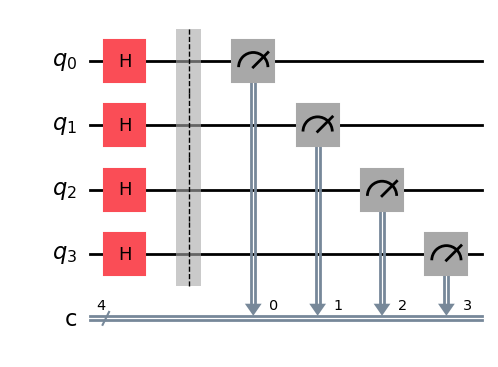

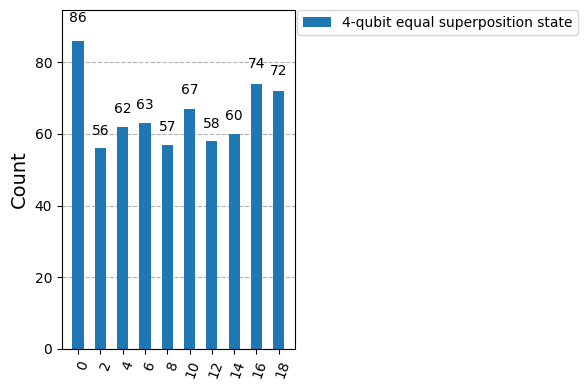

Random Outcome:  10


In [27]:
num = get_random_number_without_error_mitigation(0, 20, 2)
print("Random Outcome: ", num)

## Idea (with error mitigation):

### 1. No. of possible outcomes <= No. of superposition states = 2 ^ No. of qubits

### 2. Apply dynamical decoupling and run the circuit for 1024 shots

### 3. Discard the shots where the measured outcome is not in range

### 4. Choose the most probable outcome

##### (Note: Dynamical decoupling is an error suppression technique which involves applying a sequence of control pulses to idle qubits to cancel out unwanted interactions and coherent errors. It helps preserve quantum coherence by effectively "decoupling" the system from noise sources over time.)

In [28]:
def get_random_number_with_error_mitigation(start, stop, step, shots=1024):
    range_length = max(0, (stop - start + step + (-1 if step > 0 else 1)) // step)
    num_qubits = (range_length - 1).bit_length()
    rng = generate_rng_circuit(num_qubits)
    visualize_circuit(rng)

    backend = FakeBrisbane()
    noisy_sim = AerSimulator.from_backend(backend)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_rng = pm.run(rng)

    sampler = Sampler(mode=noisy_sim)

    sampler.options.dynamical_decoupling.enable = True

    job = sampler.run([isa_rng], shots=shots)
    result = job.result()

    counts = result[0].data.c.get_counts()
    outcomes = {}

    for key in counts:
        num = int(key, 2)
        if num < range_length:
            outcomes[start + num * step] = counts[key]
    
    plot_histogram(outcomes, legend=[f'{num_qubits}-qubit equal superposition state'], figsize=(6,4))
    plt.show()

    max_key = max(outcomes, key=outcomes.get)

    return max_key

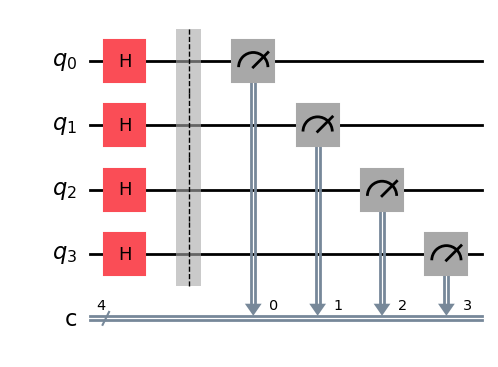

c:\Users\HP\miniconda3\envs\cwq\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:269: UserWarning: Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


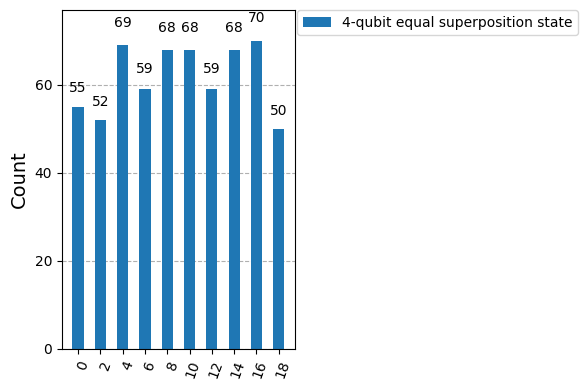

Random Outcome:  16


In [29]:
num = get_random_number_with_error_mitigation(0, 20, 2)
print("Random Outcome: ", num)